# User Test Notebook

### Objective of the notebook.

This notebook is a concise version of my broader project. It gives you the opportunity to build and fine-tune your own model for probability predictions, following the main guidelines and principles I established in my research to achieve a high-performing model. In addition, you can develop a small betting strategy that leverages this model, with the aim of outperforming bookmakers and their odds.

---

### Notebook Overview

1. Data preprocessing
2. Model definition
3. Model evaluation
4. Comparison of predicted probabilities and bookmakers’ probabilities
5. Trying to beat the bookmakers
---

### Conventions:

Every cell is introduced with a short description of what it contains and why it is included. This is indicated by a "#" frame surrounding the description. Inside the code cells, any section where you can adjust or customize the code is labeled with # TODO in blue for clarity.

---

### Quick explanation of the problem and the model I built
I treated this as a binary classification problem:
- Victory (result = 1)
- Draw or Defeat (result = 0)

For each match, I considered team A and team B separately, generating “independent” predictions for each team’s victory probability. The model ignores the correlation between the two teams’ outcomes.

In this notebook, we focus on developing a Logistic Regression model because, based on our experiments, it performed best for this probability-forecasting task.
My entire work has been devoted to optimizing everything around this model, ensuring it is as well-adapted as possible—from hyperparameter tuning to feature engineering.

In [17]:
# DEVELOPER SECTION: Skip for User Tests

#Settings relative to .ipynb file format that have to be executed here

#Make reloading of modules automatic et évite d'avoir à redémarer le kernel et tout re executer pour appliquer la modification d'un module dans __main__.
%load_ext autoreload  
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# DEVELOPER SECTION: Skip for User Tests
#src.useful_functions
import sys
sys.path.append('../src')  # Adjust the path to import modules in src/



from data import make_dataset
from data import preprocessing
from visualization import visualize
import user_test
from pipeline import model, results
from sklearn.base import clone

 <strong> <font size="5"> I) Data preprocessing

 <strong> <font size="4"> 1) Visualization of the dataset

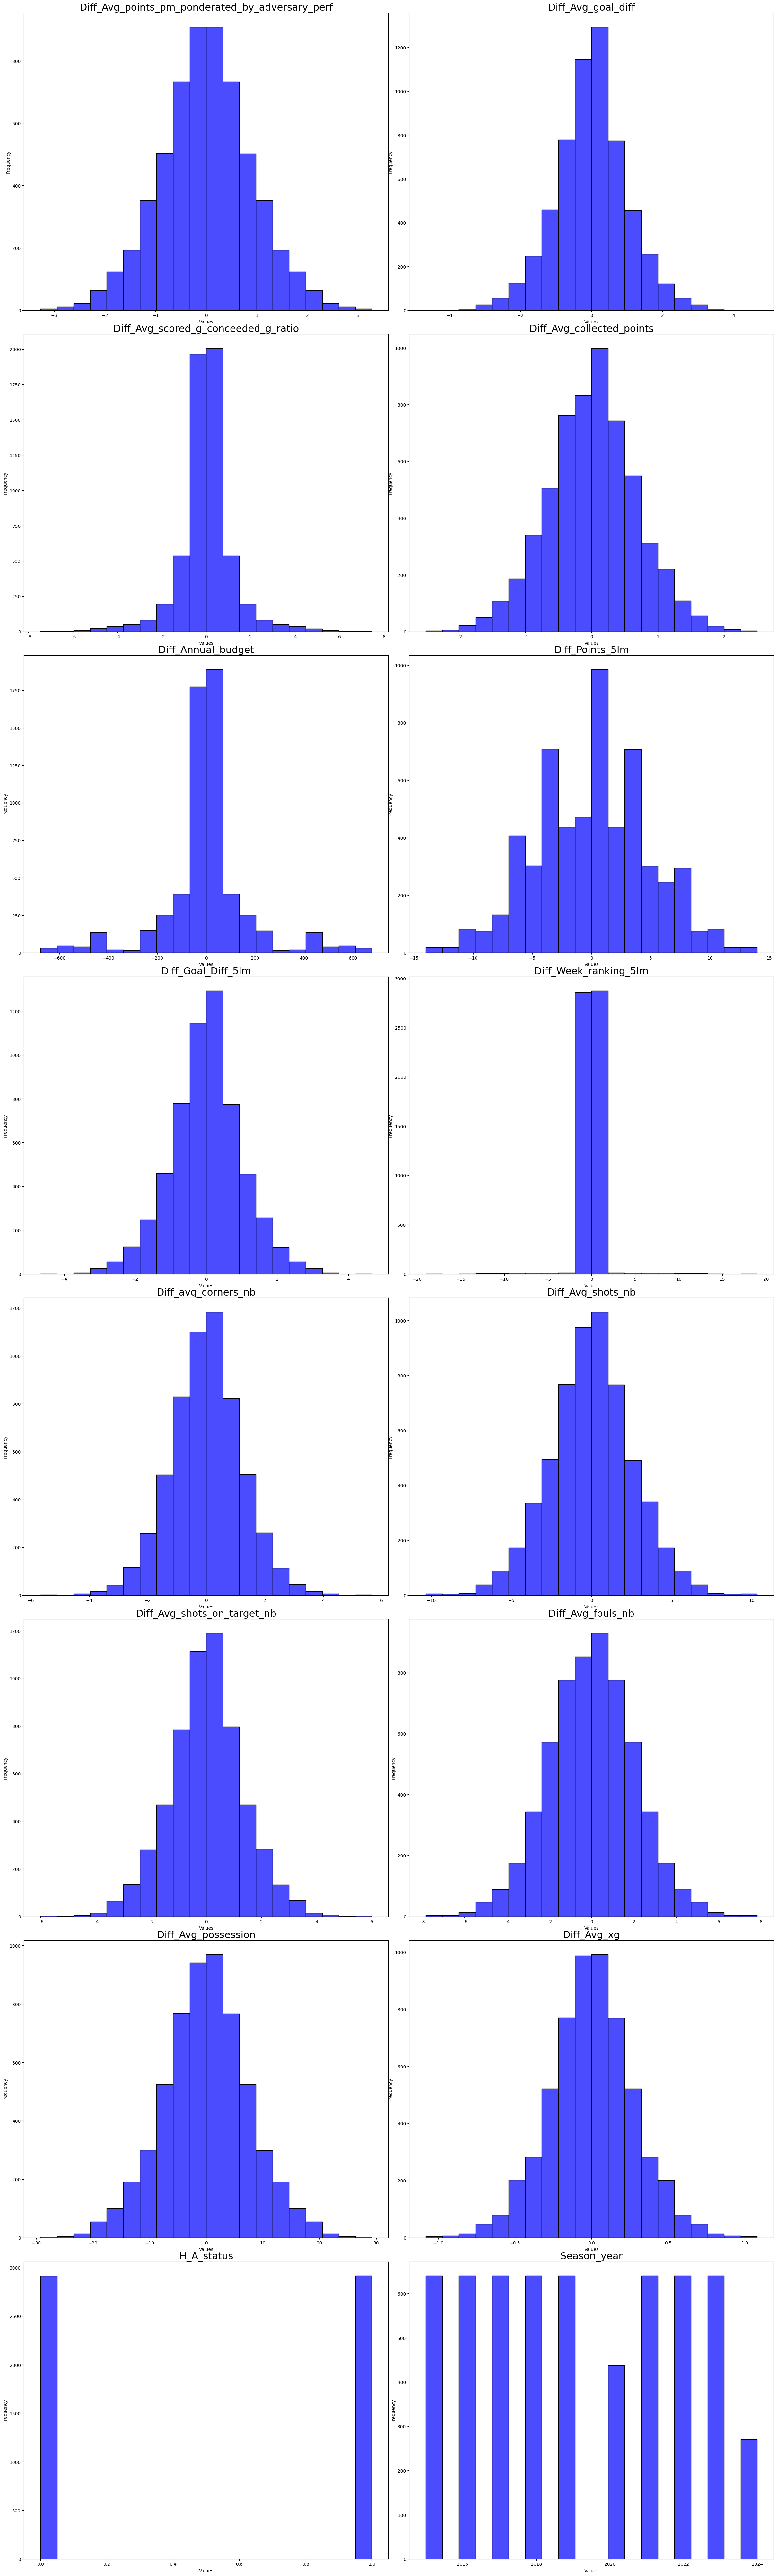

In [19]:
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  
# This cell loads the dataset, which was build through multiple steps of multi-source data gathering, data cleaning, imputation, and feature engineering.
# Generates a quick visualization of numerical features to provide an initial overview of the data.
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  


# Load the full dataset
X   = make_dataset.load_data(False, 'processed/not_split/X')
Y   = make_dataset.load_data(False, 'processed/not_split/Y')
X_info = make_dataset.load_data(False, 'processed/not_split/X_info')


# Short data visual insight
visualize.plot_all_num_features(X, save = False, density_estimate = False)

<span style="color:#228B22;"> <em> <font size="3"> Remark:

All feature names start with ‘Diff_’ because they represent the difference of a given statistic between the two opposing teams.

The features displayed above are the ones retained from a larger set of more than 150, after feature selection.


 <strong> <font size="4"> 2) Splitting the dataset by championship seasons

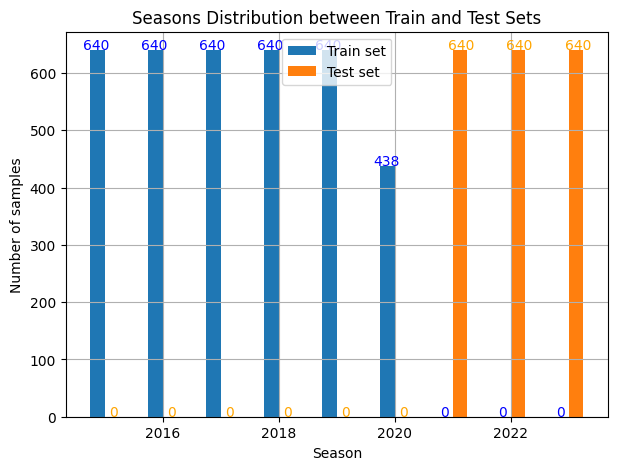

In [20]:
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  
# In this cell we load the split train and test datasets, then show the splitting structure
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  

# Load the train and test datasets:
X_train_00   = make_dataset.load_data(False, 'processed/split/X_train_00')
Y_train_00   = make_dataset.load_data(False, 'processed/split/Y_train_00')
X_test_00   = make_dataset.load_data(False, 'processed/split/X_test_00')
Y_test_00   = make_dataset.load_data(False, 'processed/split/Y_test_00')

# Display the distribution of train and test sets by season
preprocessing.hist_seasons(X_train_00.copy(), X_test_00.copy())

<span style="color:#228B22;"> <font size="4"> Remark:</font> </span> 

The shorter bar for 2020 represents the COVID season, which was interrupted before the season ended. We decided not to shuffle samples because, in a realistic scenario, we train our model before the season starts. Below, we show a more sophisticated strategy of training based on an annual schedule.

<strong> <font size="5"> II) Model definition </font> </strong> </span>

In [21]:
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  
# In this cell you set up the key parameters for your personalised pipeline.
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  

### Choose the Scaler

# Possible options:
# RobustScaler
# StandardScaler
# MinMaxScaler

Scaler = "StandardScaler"   # TODO


###  Choose how many features the selector (SelectKBest) will select among the 16 available.

# Must be in [1,16]

nb_of_feat_to_select = 5   # TODO


### Chose Logistic Rgression regularization penalty

# l1
# l2
# elasticnet
# None

penalty = 'l1'   # TODO


### Chose regularization factor
# C is the inverse of regularization strength (a smaller value corresponds to stronger regularization).

# Must be a positive number (> 0)

C = 0.8    # TODO

### Choose the L1 ratio factor (only if you chose penalty='elasticnet')

l1_ratio = 0.4   # TODO


# Create the pipeline
personalised_pipeline = user_test.create_pipeline(nb_of_feat_to_select, Scaler, penalty, C, l1_ratio)

# Pipeline training
personalised_pipeline.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())


# Just to see an example of an optimal parameter combination
# This is the best pipeline developed previously by myself
best_pipeline = model.load_pipeline("best_pipeline_trained")
print(best_pipeline)

Successfully loaded the pipeline: best_pipeline_trained


Pipeline(steps=[('scaler', StandardScaler()),
                ('features_selector', SelectKBest(k=13)),
                ('model',
                 LogisticRegression(C=0.025118864315095808, max_iter=3000,
                                    random_state=999, verbose=False))])


 <strong> <font size="5"> III) Model evaluation

<strong> <font size="4"> 1) Predictions on the test set

In [22]:
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  
# This cell generates probabilities predictions on test set with both training strategies
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  

# Generate 'normal' probability  predictions 
normal_proba_pred = personalised_pipeline.predict_proba(X_test_00)[:,1]

# Generate probability predictions by re-training the pipeline every Season
proba_pred_annual_training, Y_test_annual_training, X_info_annual_training = results.proba_prediction_retrained_each_seas(X, Y, X_info, clone(personalised_pipeline), 'season', test_seasons =[2021,2022,2023])


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\notebooks\../src\pipeline\results.py:496: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_info_pred = pd.concat([X_info_pred, X_test_info_for_this_seas], ignore_index=True, axis=0)


<span style="color:#228B22;"> <font size="4"> Remark:</font> </span> 

We first perform a classic prediction using the pipeline that was trained once on the full training set.
Then, we switch to a more advanced approach: before each new season, we retrain the pipeline on all the data 
up to that point and use the updated model to predict outcomes for the upcoming season. 
After multiple experiments, we found that retraining annually strikes the best balance between 
model stability and predictive power, outperforming a weekly retraining approach. 
This method also mirrors a more realistic scenario where the model is updated at regular intervals.

<strong> <font size="4"> 2) log-loss score computation

In [23]:
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  
# This cell calculates log-loss scores for the two training strategies and the best pipeline.
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  

# Log-loss for the normally trained pipeline
user_test.pipe_log_loss(Y_test_00, normal_proba_pred, annual_training=False)

# Log-loss for the annually retrained pipeline
user_test.pipe_log_loss(Y_test_annual_training, proba_pred_annual_training, annual_training=True)

# Log-loss for the best pipeline built
user_test.best_pipe_log_loss()

Your personnalised pipeline log-loss is:                   0.6085960794760558
Your personnalised pipeline log-loss, annualy trained, is: 0.6037731300904113
The best pipeline log-loss is:                             0.5971760558470289


<strong> <font size="4"> 3) Plot model performances

Successfully loaded the datasets: best_pipeline_results


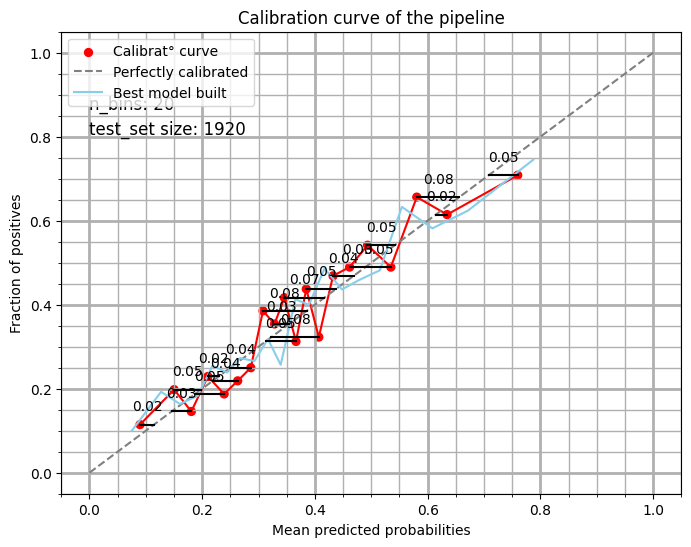

Above learning curve statistics on bins:

╒════╤════════════════╤═════════════════════════════╕
│    │ Bin interval   │   Predictions nb in the bin │
╞════╪════════════════╪═════════════════════════════╡
│  0 │ [0.03, 0.13]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  1 │ [0.13, 0.17]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  2 │ [0.17, 0.2]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  3 │ [0.2, 0.23]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  4 │ [0.23, 0.25]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  5 │ [0.25, 0.27]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  6 │ [0.27, 0.3]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  7 │ [0.3, 0.32]    │                 

In [24]:
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  
# This cell generates calibration curves and other plots to visualize how well the pipeline’s predicted probabilities match actual outcomes.
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  

# We choose wether we plot the graphs on annual training simulations or on 'normal' training simulations
plot_with_annual_training = True   # TODO

user_test.plot_pipeline_pred_results(proba_pred_annual_training, Y_test_annual_training, X_info_annual_training, normal_proba_pred, Y_test_00, X_test_00, plot_with_annual_training, best_model_plot=True)

<span style="color:#228B22;"> <font size="4"> Remark:</font> </span>

The first table shows the number of samples in each bin and the probability interval for that bin.
The second table shows, for each bin, the difference between the average true probability and the average predicted probability.


Given the better results observed with the annual training method, we have discontinued testing on the “normal” (single training) approach and will continue solely with the annually retrained pipeline predictions.

<strong> <font size="5"> IV) Comparison of predicted probabilities and bookmakers’ probabilities

In [25]:
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  
#  This cell compares the personalized pipeline’s predicted probabilities with bookmakers’ implied probabilities (calculated as 1 / odds), providing both a preview table and a full comparison. 
#  By quantifying the difference between these sets of probabilities, we can have a good assessment of our predictions qualities.
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  

# Compare the personalized pipeline's predicted probabilities with bookmakers' probabilities
odd_proba_pred_proba_compa_dataset, preview_odd_proba_pred_proba_compa_dataset, odd_proba_pred_proba_compa_dataset_df = results.compare_pred_proba_and_odds(proba_pred_annual_training.copy() ,X_info_annual_training.copy())

# Display a preview of the comparison table between predicted probabilities and bookmakers' probabilities
display(preview_odd_proba_pred_proba_compa_dataset) 

# Uncomment to display the full comparison table between predicted probabilities and bookmakers' probabilities
# display(odd_proba_pred_proba_compa_dataset)    # TODO

# Table showing the deviation statistics between predicted probabilities and bookmakers' probabilities
results.compare_pred_proba_and_odds_stats(odd_proba_pred_proba_compa_dataset_df)

# Table showing the deviation statistics for the BEST pipeline’s predicted probabilities versus bookmakers' probabilities
user_test.compare_best_pred_proba_and_odds_stats()

,Team_we_pred_vict_proba,Adversary,Game Week,Date,Played_matchs_nb,Max_victory_odd,Avg_victory_odd,Proba pred,Diff proba_pred avg_odd proba,Diff proba_pred Max_odd proba
0,Dijon,Rennes,7,2020-10-16 17:00:00,6,5.280000,5.020000,10.0%,-9.9%,-8.9%
1,Nîmes,PSG,7,2020-10-16 19:00:00,6,8.300000,7.190000,7.2%,-6.7%,-4.9%
2,Reims,Lorient,7,2020-10-17 15:00:00,6,2.200000,2.110000,29.7%,-17.7%,-15.7%
3,Marseille,Bordeaux,7,2020-10-17 19:00:00,6,2.130000,2.030000,37.0%,-12.2%,-9.9%
4,Strasbourg,Lyon,7,2020-10-18 11:00:00,6,3.700000,3.460000,11.7%,-17.2%,-15.3%
5,Angers,Metz,7,2020-10-18 13:00:00,6,2.180000,2.040000,34.0%,-15.0%,-11.8%
6,Monaco,Montpellier,7,2020-10-18 13:00:00,6,1.540000,1.500000,48.6%,-18.1%,-16.3%
7,Nantes,Brest,7,2020-10-18 13:00:00,6,2.220000,2.140000,29.2%,-17.5%,-15.8%
8,St Etienne,Nice,7,2020-10-18 15:00:00,6,2.430000,2.340000,28.1%,-14.6%,-13.1%
9,Lille,Lens,7,2020-10-18 19:00:00,6,1.970000,1.870000,45.9%,-7.6%,-4.8%


,Mean Absolute Difference (%),25th Percentile (%),Median (%),75th Percentile (%)
Diff proba_pred avg_odd proba,7.4,3.1,6.5,10.4


,Mean Absolute Difference (%),25th Percentile (%),Median (%),75th Percentile (%)
Diff proba_pred avg_odd proba,4.8,1.7,3.8,6.7


<span style="color:#228B22;"> <font size="4"> Remark:</font> </span> 

We have to be careful with bookmaker probabilities because they are not computed to represent the exact probability of winning. They also depend on bettors’ behavior, which introduces bias.

<strong> <font size="5"> V) Trying to beat the bookmakers

In [26]:
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  
# Define your strategy parameters to try to beat the bookmakers with the model you built.
# We aim to identify the matches in which bookmakers have underestimated a team’s winning probability compared to our predictions.
# Then we place bets on these matches, expecting positive returns over the long term.
# The goal is to specify how we decide which bets are worthwhile.
# #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  #  

# 1. Probability interval: The range of predicted probabilities to consider for betting.
#    Low and high probability predictions are more prone to bias, as our model is less accurate in these intervals.
proba_interval_0 = [0.05, 0.6]  # TODO

# 2. Minimum difference with bookmakers' probability: The required gap between our predicted probability and the bookmakers' probability.
min_diff_with_odd_proba_0 = 0.05  # TODO

# 3. Game week interval: The range of game weeks to consider for betting (minimum 5).
#    Early in the season, we have less information about the teams, so our model might not perform well.
GW_interval_0 = [6, 37]  # TODO

# 4. Bet amount: The amount of money to bet on each match
bet_0 = 10  # TODO

# Run the betting simulation with the chosen parameters
results_dataset = results.betting_simulation(
    compa_dataset=odd_proba_pred_proba_compa_dataset_df,
    Y_0=Y_test_annual_training,
    proba_interval_0=proba_interval_0,
    min_diff_with_odd_proba_0=min_diff_with_odd_proba_0,
    GW_interval_0=GW_interval_0,
    bet_0=bet_0
)

# Display the results
display(results_dataset)

Congratulation, you beat the bookmakers!
The final gain is 554.3 € , betting on 499 matches, out of 1920
This is equivalent to a net gain-to-bet ratio = 11.11 %


,Team_we_pred_vict_proba,Adversary,Game Week,Date,Played_matchs_nb,Max_victory_odd,Avg_victory_odd,Proba pred,Diff proba_pred avg_odd proba,Diff proba_pred Max_odd proba,Result,Gain
10,Rennes,Angers,8,2020-10-23 19:00:00,7,2.15,2.07,0.593920,0.110828,0.128803,0,-10.0
16,Montpellier,Reims,8,2020-10-25 14:00:00,7,2.17,2.08,0.531231,0.050462,0.070402,0,-10.0
19,Rennes,Brest,9,2020-10-31 16:00:00,8,2.06,1.99,0.563931,0.061419,0.078495,1,10.6
90,Nice,Lyon,16,2020-12-19 20:00:00,14,6.50,5.50,0.241340,0.059522,0.087494,0,-10.0
142,Dijon,Strasbourg,21,2021-01-24 14:00:00,19,3.86,3.68,0.315040,0.043301,0.055972,0,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1906,Ajaccio,Lens,37,2023-05-27 19:00:00,36,29.00,22.72,0.101300,0.057286,0.066817,0,-10.0
1912,Toulouse,Monaco,38,2023-06-03 19:00:00,37,6.50,6.09,0.341792,0.177588,0.187946,1,55.0
1914,Angers,Nantes,38,2023-06-03 19:00:00,37,9.00,7.95,0.283983,0.158197,0.172872,0,-10.0
1915,Lyon,Nice,38,2023-06-03 19:00:00,37,2.84,2.72,0.460606,0.092959,0.108493,0,-10.0


<span style="color:#228B22;"> <font size="4"> Remark:</font> </span> 

Above we displayed the table with the matches we bet on following our strategy.